# Preparing the dataset for hippocampus segmentation

In this notebook you will use the skills and methods that we have talked about during our EDA Lesson to prepare the hippocampus dataset using Python. Follow the Notebook, writing snippets of code where directed so using Task comments, similar to the one below, which expects you to put the proper imports in place. Write your code directly in the cell with TASK comment. Feel free to add cells as you see fit, but please make sure that code that performs that tasked activity sits in the same cell as the Task comment.


In [24]:
# TASK: Import the following libraries that we will use: nibabel, matplotlib, numpy
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
from shutil import copy
from glob import glob


It will help your understanding of the data a lot if you were able to use a tool that allows you to view NIFTI volumes, like [3D Slicer](https://www.slicer.org/). I will refer to Slicer throughout this Notebook and will be pasting some images showing what your output might look like.

## Loading NIFTI images using NiBabel

NiBabel is a python library for working with neuro-imaging formats (including NIFTI) that we have used in some of the exercises throughout the course. Our volumes and labels are in NIFTI format, so we will use nibabel to load and inspect them.

NiBabel documentation could be found here: https://nipy.org/nibabel/

Our dataset sits in two directories - *images* and *labels*. Each image is represented by a single file (we are fortunate to have our data converted to NIFTI) and has a corresponding label file which is named the same as the image file.

Note that our dataset is "dirty". There are a few images and labels that are not quite right. They should be quite obvious to notice, though. The dataset contains an equal amount of "correct" volumes and corresponding labels, and you don't need to alter values of any samples in order to get the clean dataset.

In [2]:
# TASK: Your data sits in directory /data/TrainingSet.
# Load an image and a segmentation mask into variables called image and label
image = nib.load('../data/TrainingSet/images/hippocampus_042.nii.gz')
label = nib.load('../data/TrainingSet/labels/hippocampus_042.nii.gz')

Lets visualize few Axial Slices

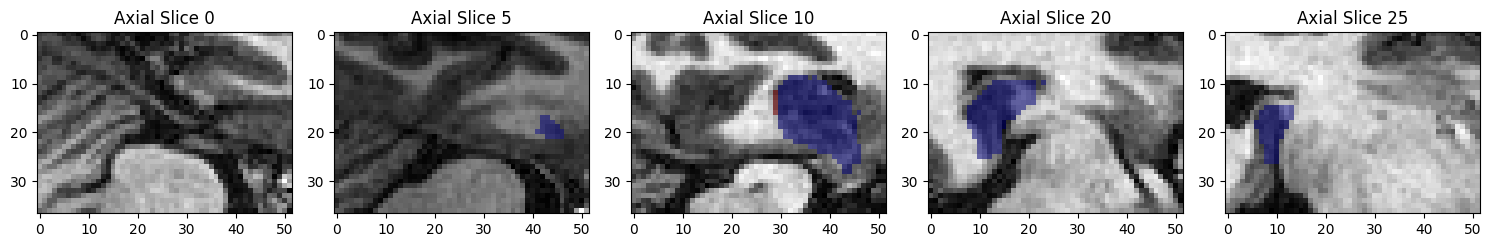

In [9]:
# Nibabel can present your image data as a Numpy array by calling the method get_fdata()
# The array will contain a multi-dimensional Numpy array with numerical values representing voxel intensities. 
# In our case, images and labels are 3-dimensional, so get_fdata will return a 3-dimensional array. You can verify this
# by accessing the .shape attribute. What are the dimensions of the input arrays?

# TASK: using matplotlib, visualize a few slices from the dataset, along with their labels. 
# You can adjust plot sizes like so if you find them too small:
# plt.rcParams["figure.figsize"] = (10,10)

image_np = image.get_fdata()
label_np = label.get_fdata()

fig, axes = plt.subplots(1, 5, figsize=(15, 15))

slice_list = [0, 5, 10, 20, 25]
for idx, z in enumerate(slice_list):
    image_slice = image_np[:, :, z]
    label_slice = label_np[:, :, z]

    masked_overlay = np.ma.masked_where(label_slice == 0, label_slice)  # Mask non-segmented areas

    axes[idx].imshow(image_slice, cmap='gray')
    axes[idx].imshow(masked_overlay, cmap='jet', alpha=0.5)
    axes[idx].set_title(f'Axial Slice {z}')

plt.tight_layout()
plt.show()


Lets visualize few Coronal Slices

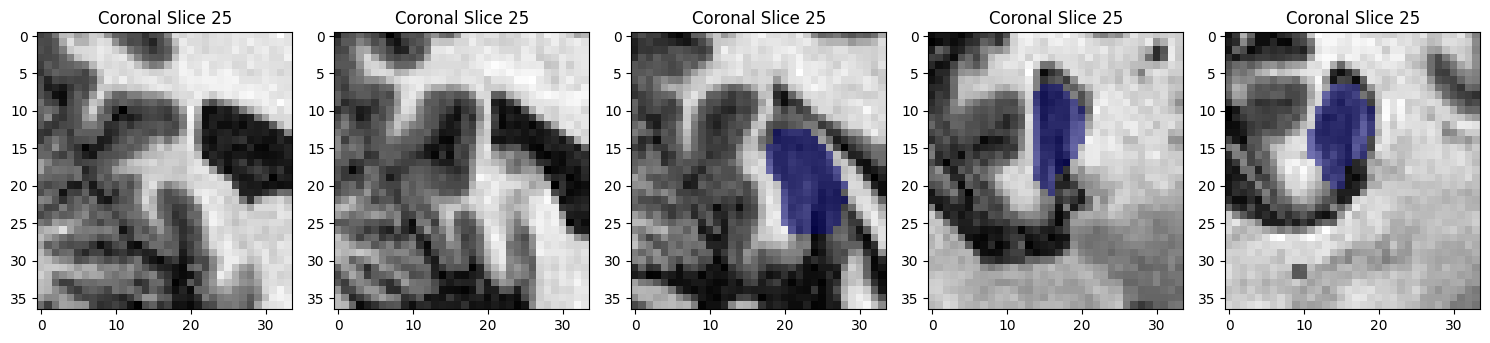

In [10]:
fig1, axes1 = plt.subplots(1, 5, figsize=(15, 15))

for idx, y in enumerate(slice_list):
    image_slice = image_np[:, y, :]
    label_slice = label_np[:, y, :]

    masked_overlay = np.ma.masked_where(label_slice == 0, label_slice)  # Mask non-segmented areas

    axes1[idx].imshow(image_slice, cmap='gray')
    axes1[idx].imshow(masked_overlay, cmap='jet', alpha=0.5)
    axes1[idx].set_title(f'Coronal Slice {z}')

plt.tight_layout()
plt.show()

Lets visualize few Sagittal slices

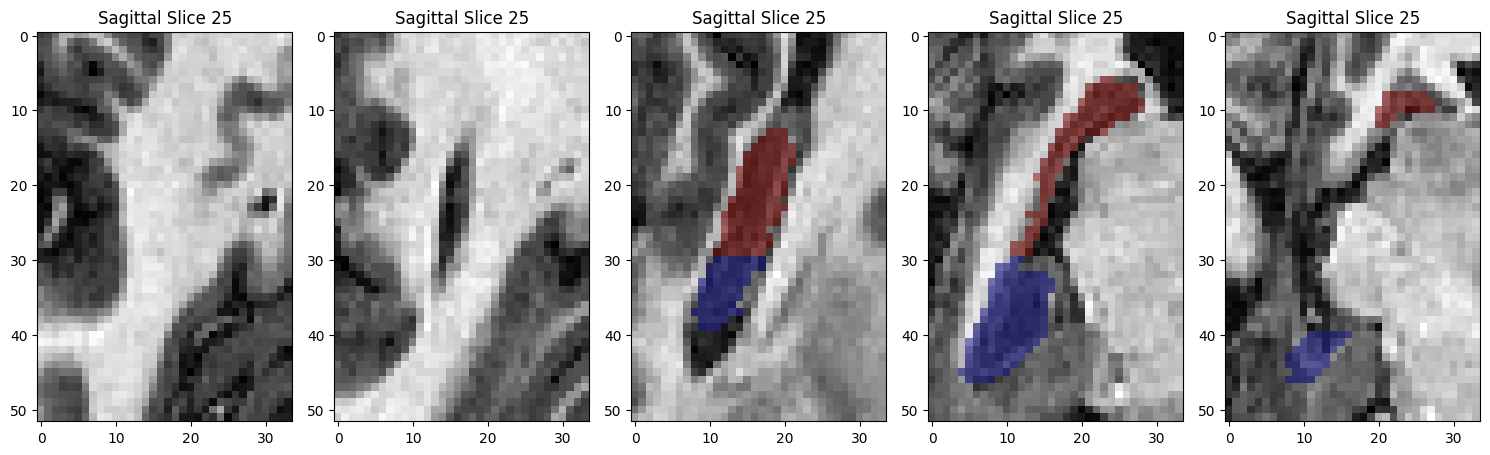

In [11]:
fig2, axes2 = plt.subplots(1, 5, figsize=(15, 15))

for idx, x in enumerate(slice_list):
    image_slice = image_np[x, :, :]
    label_slice = label_np[x, :, :]

    masked_overlay = np.ma.masked_where(label_slice == 0, label_slice)  # Mask non-segmented areas

    axes2[idx].imshow(image_slice, cmap='gray')
    axes2[idx].imshow(masked_overlay, cmap='jet', alpha=0.5)
    axes2[idx].set_title(f'Sagittal Slice {z}')

plt.tight_layout()
plt.show()

Load volume into 3D Slicer to validate that visualization is correct and get a feel for the shape of structures.
![3D slicer](3DSlicerVisulization.png)

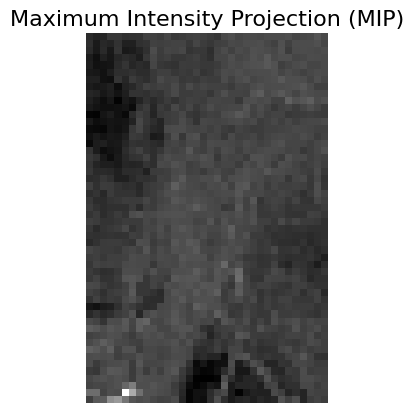

In [12]:
# Stand out suggestion: use one of the simple Volume Rendering algorithms that we've
# implemented in one of our earlier lessons to visualize some of these volumes

mip = np.zeros((image_np.shape[1], image_np.shape[2]))
for z in range(image_np.shape[0]):
    mip = np.maximum(mip, image_np[z, :, :])

plt.imshow(mip, cmap='gray')
plt.title("Maximum Intensity Projection (MIP)", fontsize=16)  # Adding title
plt.axis("off")  # Optional: Hide axes for a cleaner image
plt.show()



## Looking at single image data
In this section we will look closer at the NIFTI representation of our volumes. In order to measure the physical volume of hippocampi, we need to understand the relationship between the sizes of our voxels and the physical world.

In [53]:
# Nibabel supports many imaging formats, NIFTI being just one of them. I told you that our images 
# are in NIFTI, but you should confirm if this is indeed the format that we are dealing with
# TASK: using .header_class attribute - what is the format of our images?
print(f'File Format {image.header_class}')

File Format <class 'nibabel.nifti1.Nifti1Header'>


Further down we will be inspecting .header attribute that provides access to NIFTI metadata. You can use this resource as a reference for various fields: https://brainder.org/2012/09/23/the-nifti-file-format/

In [13]:
# TASK: How many bits per pixel are used?
# Access the header
header = image.header

# Get the bitpix value
bitpix = header["bitpix"]

print(f'Bits per pixel: {bitpix}')



Bits per pixel: 32


In [14]:
# TASK: What are the units of measurement?
unit_measurement = header["xyzt_units"]
binary_representation = format(unit_measurement, "08b")

# Extract spatial (bits 1-3) and temporal (bits 4-6)
space_units = binary_representation[-3:]  # Spatial measurement
time_units = binary_representation[-6:-3]  # Temporal measurement

# Define unit mappings based on NIfTI standard
space_dict = {"001": "Meters", "010": "Millimeters", "011": "Micrometers"}
time_dict = {"001": "Seconds", "010": "Milliseconds", "011": "Microseconds"}

# Interpret values
space_label = space_dict.get(space_units, "Unknown")
time_label = time_dict.get(time_units, "Unknown")

print(f"Binary representation: {binary_representation}")
print(f"Spatial units: {space_units} → {space_label}")
print(f"Temporal units: {time_units} → {time_label}")


Binary representation: 00001010
Spatial units: 010 → Millimeters
Temporal units: 001 → Seconds


In [15]:
# TASK: Do we have a regular grid? What are grid spacings?
pixel_dimension = header["pixdim"]
print(pixel_dimension)

x_spacing = pixel_dimension[1]
y_spacing = pixel_dimension[2]
z_spacing = pixel_dimension[3]

# Check if spacing is regular
if x_spacing == y_spacing == z_spacing:
    print(f"Grid is regular with spacing: {x_spacing} mm")
else:
    print(f"Grid is irregular")



[1. 1. 1. 1. 1. 0. 0. 0.]
Grid is regular with spacing: 1.0 mm


In [16]:
# TASK: What dimensions represent axial, sagittal, and coronal slices? How do you know?

# Extract dimensions from 'dim'
dim = header["dim"]

# Assign anatomical planes based on dimension indexing
x_dim, y_dim, z_dim = dim[1], dim[2], dim[3]

# Define mapping
orientation_map = {
    "Axial": (x_dim, y_dim, z_dim),     # X-Y plane, Z controls slices
    "Sagittal": (y_dim, z_dim, x_dim),  # Y-Z plane, X controls slices
    "Coronal": (x_dim, z_dim, y_dim)    # X-Z plane, Y controls slices
}

# Print results
for plane, dims in orientation_map.items():
    print(f"{plane} view: X={dims[0]}, Y={dims[1]}, Z={dims[2]} (Slice changes along {dims[2]})")



Axial view: X=37, Y=52, Z=34 (Slice changes along 34)
Sagittal view: X=52, Y=34, Z=37 (Slice changes along 37)
Coronal view: X=37, Y=34, Z=52 (Slice changes along 52)


In [80]:
# By now you should have enough information to decide what are dimensions of a single voxel
# TASK: Compute the volume (in mm³) of a hippocampus using one of the labels you've loaded. 
# You should get a number between ~2200 and ~4500

# Compute voxel volume
voxel_volume = x_spacing * y_spacing * z_spacing

# Compute total volume (sum of labeled voxels multiplied by voxel volume)
total_volume = np.sum(label_np > 0) * voxel_volume  # Assumes label voxel

print(f"Voxel Volume: {voxel_volume:.3f} mm³")
print(f"Total Segmented Volume: {total_volume:.3f} mm³")

Voxel Volume: 1.000 mm³
Total Segmented Volume: 3847.000 mm³


## Plotting some charts

Text(0.5, 1.0, 'Histogram of Original All Data')

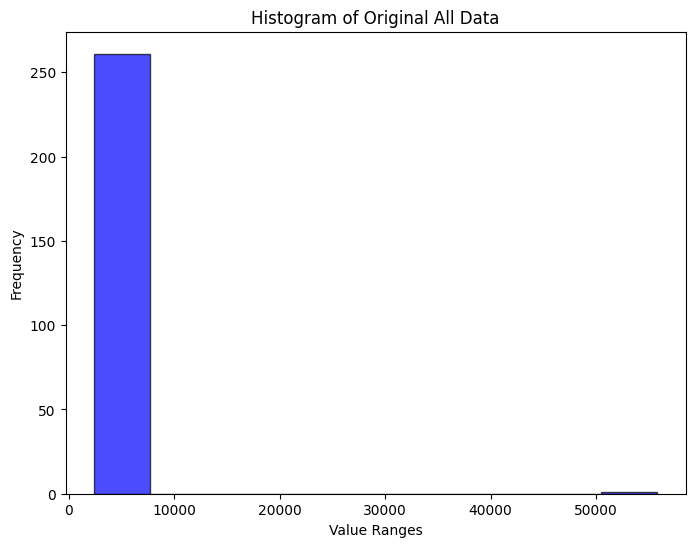

In [37]:
# TASK: Plot a histogram of all volumes that we have in our dataset and see how 
# our dataset measures against a slice of a normal population represented by the chart below.

def compute_segmented_volume(nifti_label_path):
    """
    Compute segmented volume from a NIfTI label file.
    
    Args:
        nifti_label_path (str): Path to the NIfTI label file (.nii or .nii.gz)
    
    Returns:
        float: Total segmented volume in cubic millimeters
    """
    # Load NIfTI label file
    nifti_label = nib.load(nifti_label_path)
    header = nifti_label.header
    label_data = nifti_label.get_fdata()

    # Extract voxel spacing from pixdim
    x_spacing, y_spacing, z_spacing = header["pixdim"][1:4]

    # Compute voxel volume
    voxel_volume = x_spacing * y_spacing * z_spacing

    # Compute total segmented volume (sum of labeled voxels multiplied by voxel volume)
    total_volume = np.sum(label_data > 0) * voxel_volume  # Assumes segmentation labels are > 0
    
    return total_volume

train_volumes = []
label_files = glob('../data/TrainingSet/labels/*.nii.gz')
for label_file in label_files:
    volume = compute_segmented_volume(label_file)
    train_volumes.append(volume)

# Define bin ranges dynamically (e.g., 10 bins between min & max)
num_bins = 10
bin_edges = np.linspace(min(train_volumes), max(train_volumes), num_bins + 1)

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(train_volumes, bins=bin_edges, color="blue", edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Value Ranges")
plt.ylabel("Frequency")
plt.title("Histogram of Original All Data")


<img src="img/nomogram_fem_right.svg" width=400 align=left>

We can see from the histogram and chart provided that we have few outliers in out dataset, these need to be removed from our training dataset

['hippocampus_281.nii']
Skipping ../data/TrainingSet/labels\hippocampus_281.nii.gz


Text(0.5, 1.0, 'Histogram of Filtered Data')

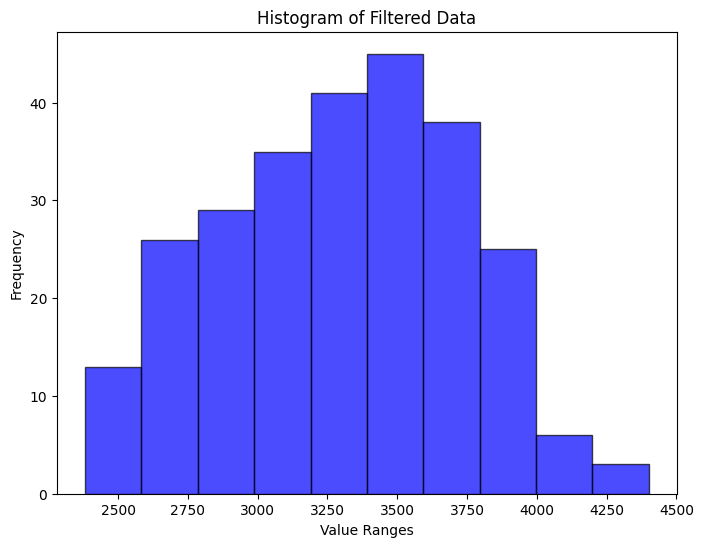

In [42]:
files_to_discard = []

for label_file in label_files:
    volume = compute_segmented_volume(label_file)
    if volume > 5000:
        label_name = os.path.splitext(os.path.basename(label_file))[0]
        files_to_discard.append(label_name) 

print(files_to_discard)

# Recalculate histogram by excluding this file
train_volumes = []
label_files = glob('../data/TrainingSet/labels/*.nii.gz')
for label_file in label_files:
    label_name = os.path.splitext(os.path.basename(label_file))[0]
    if label_name in files_to_discard:
        print(f"Skipping {label_file}")
        continue

    
    volume = compute_segmented_volume(label_file)
    train_volumes.append(volume)

# Define bin ranges dynamically (e.g., 10 bins between min & max)
num_bins = 10
bin_edges = np.linspace(min(train_volumes), max(train_volumes), num_bins + 1)

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(train_volumes, bins=bin_edges, color="blue", edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Value Ranges")
plt.ylabel("Frequency")
plt.title("Histogram of Filtered Data")





Do you see any outliers? Why do you think it's so (might be not immediately obvious, but it's always a good idea to inspect) outliers closer. If you haven't found the images that do not belong, the histogram may help you.

In the real world we would have precise information about the ages and conditions of our patients, and understanding how our dataset measures against population norm would be the integral part of clinical validation that we talked about in last lesson. Unfortunately, we do not have this information about this dataset, so we can only guess why it measures the way it is. If you would like to explore further, you can use the [calculator from HippoFit project](http://www.smanohar.com/biobank/calculator.html) to see how our dataset compares against different population slices

Did you notice anything odd about the label files? We hope you did! The mask seems to have two classes, labeled with values `1` and `2` respectively. If you visualized sagittal or axial views, you might have gotten a good guess of what those are. Class 1 is the anterior segment of the hippocampus and class 2 is the posterior one. 

For the purpose of volume calculation we do not care about the distinction, however we will still train our network to differentiate between these two classes and the background

In [48]:

# Check for label and image consistency
# Get file names without extensions
image_folder = '../data/TrainingSet/images/'
label_folder = '../data/TrainingSet/labels/'

# Get file names without extensions using glob
image_files = {os.path.splitext(os.path.basename(f))[0]: f for f in glob(os.path.join(image_folder, "*.nii*"))}
label_files = {os.path.splitext(os.path.basename(f))[0]: f for f in glob(os.path.join(label_folder, "*.nii*"))}

# Find mismatched filenames
missing_labels = set(image_files.keys()) - set(label_files.keys())
missing_images = set(label_files.keys()) - set(image_files.keys())

# Add these to files_to_discard list

for missing_label in missing_labels:
    if missing_label not in files_to_discard:
        files_to_discard.append(missing_label)

for missing_image in missing_images:
    if missing_image not in files_to_discard:
        files_to_discard.append(missing_image)


for name in image_files.keys() & label_files.keys():  # Only check matching names
    img = nib.load(image_files[name]).get_fdata()
    lbl = nib.load(label_files[name]).get_fdata()

    if img.shape != lbl.shape:
        # In case of mismatch aad these to the list of files_to_discard
        if name not in files_to_discard:
            files_to_discard.append(name)

# These files need to be removed from section 2 model training analysis
print(f"Files to discard: {files_to_discard}")


# Copy the clean dataset to the output folder inside section1/out. We will use it in the next Section
image_out = "./out/data/TrainingSet/images"
label_out = "./out/data/TrainingSet/labels"

for name in image_files.keys() & label_files.keys():
    if name in files_to_discard:
        print(f"Skipping {name}")
        continue

    src_img   = os.path.join(image_folder, name + ".gz")
    src_label = os.path.join(label_folder, name + ".gz")

    dest_img   = os.path.join(image_out, name + ".gz")
    dest_label = os.path.join(label_out, name + ".gz")

    copy(src_img, dest_img)
    print(f" Copied {src_img} to {dest_img}")

    copy(src_label, dest_label)
    print(f" Copied {src_label} to {dest_label}")




Files to discard: ['hippocampus_281.nii', 'hippocampus_118.nii', 'hippocampus_010.nii']
 Copied ../data/TrainingSet/images/hippocampus_366.nii.gz to ./out/data/TrainingSet/images\hippocampus_366.nii.gz
 Copied ../data/TrainingSet/labels/hippocampus_366.nii.gz to ./out/data/TrainingSet/labels\hippocampus_366.nii.gz
 Copied ../data/TrainingSet/images/hippocampus_204.nii.gz to ./out/data/TrainingSet/images\hippocampus_204.nii.gz
 Copied ../data/TrainingSet/labels/hippocampus_204.nii.gz to ./out/data/TrainingSet/labels\hippocampus_204.nii.gz
 Copied ../data/TrainingSet/images/hippocampus_034.nii.gz to ./out/data/TrainingSet/images\hippocampus_034.nii.gz
 Copied ../data/TrainingSet/labels/hippocampus_034.nii.gz to ./out/data/TrainingSet/labels\hippocampus_034.nii.gz
 Copied ../data/TrainingSet/images/hippocampus_220.nii.gz to ./out/data/TrainingSet/images\hippocampus_220.nii.gz
 Copied ../data/TrainingSet/labels/hippocampus_220.nii.gz to ./out/data/TrainingSet/labels\hippocampus_220.nii.gz


## Final remarks

Congratulations! You have finished Section 1. 

In this section you have inspected a dataset of MRI scans and related segmentations, represented as NIFTI files. We have visualized some slices, and understood the layout of the data. We have inspected file headers to understand what how the image dimensions relate to the physical world and we have understood how to measure our volume. We have then inspected dataset for outliers, and have created a clean set that is ready for consumption by our ML algorithm. 

In the next section you will create training and testing pipelines for a UNet-based machine learning model, run and monitor the execution, and will produce test metrics. This will arm you with all you need to use the model in the clinical context and reason about its performance!